# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


In [ ]:
!nvidia-smi

Thu Jul  7 15:57:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set up the environment


### Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [ ]:
!gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [ ]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

replace ./faces/30553.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [ ]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


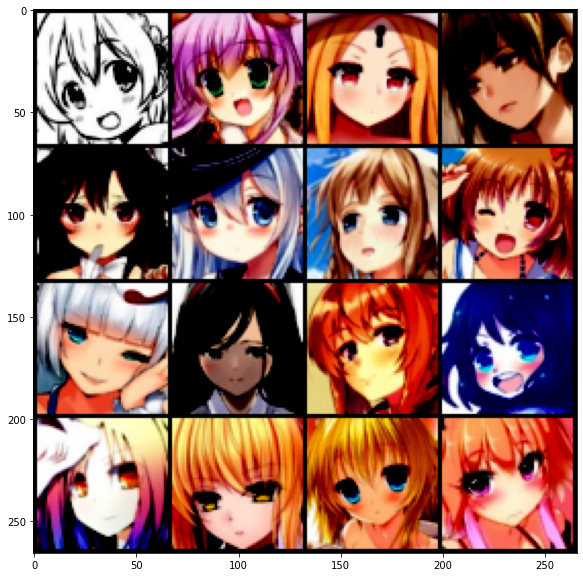

In [ ]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

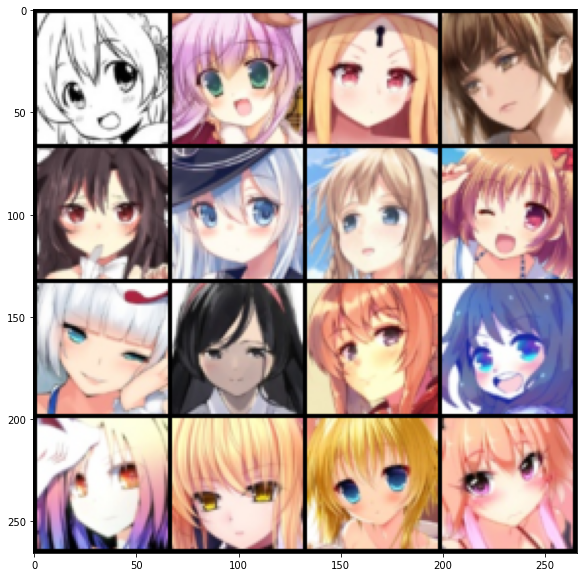

In [ ]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y


class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
            
        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            # nn.Sigmoid(), 
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [ ]:
# Training hyperparameters
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 50 # 50
n_critic = 5 # 5
clip_value = 0.01

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
# opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)


# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [ ]:
def compute_gradient_penalty(D, r_imgs, f_imgs):
  alpha = Tensor(np.random.random((r_imgs.size(0), 1, 1, 1)))
  x_hat = (alpha * r_imgs + (1 - alpha)* f_imgs).requires_grad_(True)

  d_x_hat = D(x_hat)
  fake = Variable(Tensor(r_imgs.shape[0]).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
  gradients = torch.autograd.grad(
        outputs=d_x_hat,
        inputs=x_hat,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
  )[0]
  gradients = gradients.view(gradients.size(0), -1)
  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty



In [ ]:
Tensor = torch.cuda.FloatTensor
steps = 0
lambda_gp = 10
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        """ Medium: Use WGAN Loss. """
        # Label
        # r_label = torch.ones((bs)).cuda()
        # f_label = torch.zeros((bs)).cuda()

        # # Model forwarding
        # r_logit = D(r_imgs.detach())
        # f_logit = D(f_imgs.detach())
        
        # # Compute the loss for the discriminator.
        # r_loss = criterion(r_logit, r_label)
        # f_loss = criterion(f_logit, f_label)
        # loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs)) + lambda_gp * compute_gradient_penalty(D, r_imgs, f_imgs)
                                                                                  
       
        # WGAN+GP


        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        # for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs = G(z)

            # Model forwarding
            f_logit = D(f_imgs)
            
            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            # loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    
    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (e+1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))



Output hidden; open in https://colab.research.google.com to view.

## Inference
Use the trained model to generate anime faces!

### Load model 

In [ ]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.cuda()

NameError: ignored

### Generate and show some images.


In [ ]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/output
/content
